# Understanding the Impacts of China-US Trade War

## Abstract

Since the paper introduces interrupted time series (ITS) analysis as a practical method for event’s impact evaluation, we propose to study if we can apply ITS analysis to a different scenario: the China-United States trade war. To do so, we collect several different types of datasets (e.g., U.S. Trade in Goods with China, US foreign trade with product details) from the United States and China’s official website. We will then use ITS analysis on these datasets and see if there exists a significant impact on China-US trade. Moreover, we may try to extend the ITS analysis method to better interpret multiple events and other factors (e.g. tariffs). The visualization of analysis will allow us to understand the economic outcomes easily. Apart from the general implications for exports and imports, we are also interested in investigating further into other aspects of the trade war: increasing tariffs during the trade war, different levels of impacts in various industries, the resulting change in the trade of their business partners such as the European Union. All these results would provide us with a deeper understanding of the impacts of the trade war, and we would try to interpret them from different perspectives. (Need to be improved)

![tradewar-img](https://knowledge.wharton.upenn.edu/wp-content/uploads/2019/08/U.S.-China-Trade-War-Tariffs.jpg)

In [1]:
# All the packages used
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
pd.options.display.max_rows = 10

## Constant and Function Definition

In the following analysis of different questions, there are some constants and functions frequently used in data loading or interrupted times series (ITS) analysis. We will define them here to make the work easier and more clear. Detailed explanation of each function has been covered in its docstring.

In [2]:
# Constant definition
BILATERAL_TRADE_PATH = "./data/trade.csv"


In [3]:
def add_its_features(df, time_col_name, intervention_time):
    """
    For extending the pandas dataframe with features required in interrupted times series (ITS) analysis.
    
    ITS features include:
        - `time_feature` : a continuous variable indicating time from the start of the study up to the end of the period of observation;
        - `intervention` : coded 0 for pre-intervention time points and 1 for post-intervention time points
        - `postslope`    : coded 0 up to the last point before the intervention phase and coded sequentially from 1 thereafter
    
    Parameters
    ----------
    df : pandas Dataframe
        dataframe prepared for ITS analysis
    time_col_name : string
        the column name of time series in the dataframe
    intervention_time : string
        the time of the interrupted event
    Returns
    -------
    df_its : pandas Dataframe
        dataframe df with extended ITS features
    """
    
    df_its = df.copy(deep=True)
    time = list(range(1, len(df_its) + 1))
    df_its["time_feature"] = time
    
    df_its["intervention"] = None
    df_its["intervention"].mask(df_its[time_col_name] <= intervention_time, 0, inplace=True)
    df_its["intervention"].mask(df_its[time_col_name] > intervention_time, 1, inplace=True)
    
    pre = df_its[df_its[time_col_name] <= intervention_time]
    post = df_its[df_its[time_col_name] > intervention_time]
    postslope_pre = [0 for i in range(len(pre))]
    postslope_post = list(range(1, len(post) + 1))
    postslope = postslope_pre + postslope_post
    df_its["postslope"] = postslope
    
    return df_its

In [4]:
def plot_its_result(df, reg_res, time_col_name, target_col_name, intervention_time, title):
    """
    For plotting the ITS regression analysis, specified with the two time periods: pre-intervention and post-intervention.
    
    Parameters
    ----------
    df : pandas Dataframe
        dataframe prepared for ITS analysis
    reg_res : statsmodels RegressionResultsWrapper
        the regression result of its, including the coefficients
    time_col_name : string
        the column name of time series in the dataframe
    target_col_name : string
        the column name of the target variable
    intervention_time : string
        the time of the interrupted event
    """
    # Set the plotting format
    sns.set_style("ticks")
    plt.figure(figsize=(12, 6))

    # Retrieve the coefficients of the segmented regression model
    beta_0, beta_2, beta_1, beta_3 = reg_res.params # intercept, intervention, time_feature, postslope

    # Generate datapoints for the pre-period
    pre = df[df[time_col_name] <= intervention_time]
    pre_month_num = len(pre)
    X_plot_pre = np.linspace(1, pre_month_num, 100)
    Y_plot_pre = beta_0 + beta_1 * X_plot_pre 

    # Generate datapoints for the post-period
    X_plot_post = np.linspace(pre_month_num+1, len(df), 100)
    Y_plot_post = beta_0 + beta_1 * X_plot_post + beta_2 * 1 + beta_3 * (X_plot_post-pre_month_num)

    # Visualization
    g = sns.pointplot(x=df["time_feature"], y=df[target_col_name], 
                        color='black', label=target_col_name+" (By Month)")

    # Set the axis and format
    g.set_title(title, loc="left", fontsize=14, weight="bold")
    g.set_xlabel("Time (Months)")
    g.set_xticks(list(range(0, len(df), 1)))
    g.set_ylabel("Total Amount (millions of U.S. dollars)")
    g.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p:format(int(x), ',')))

    # Plot the two regression lines (pre/post)
    plt.plot(X_plot_pre, Y_plot_pre, color="black", label="Trend Pre-Trade War")
    plt.plot(X_plot_post, Y_plot_post, color="gray", label="Trend Post-Trade War")

    # Mark the position of the intervention
    plt.axvline(pre_month_num + 0.5, color="black", linestyle="--")
    plt.text(pre_month_num + 2.5, max(df[target_col_name]), intervention_time, ha="center")

    plt.legend()
    plt.show()
    
    return 

## 1. How does the trade war affect the bilateral trade between China and the US?

The core question in our research is the analysis of trade war's direct impacts on the bilateral trade, including exports and imports amount. First we load the data from the United States Census website:

In [5]:
bilateral_df = pd.read_csv(BILATERAL_TRADE_PATH)
bilateral_df

,time,exports,imports
0,2016-01,8208.9,37126.4
1,2016-02,8080.5,36066.9
2,2016-03,8925.6,29812.3
3,2016-04,8679.7,32920.2
4,2016-05,8542.0,37513.7
...,...,...,...
52,2020-05,9641.7,36598.2
53,2020-06,9242.2,37639.5
54,2020-07,9037.0,40657.3
55,2020-08,11036.1,40816.4


Then we need to convert the data type of each columns and add the ITS feature required for segmented regression analysis. Given that the U.S. took actions to apply tariffs on Chinese goods on March 2018 for the first time, we chose it as the trade war event intervention in our analysis.

In [6]:
# Convert the datatype to datetime/numeric
bilateral_df.time    = pd.to_datetime(bilateral_df.time)
bilateral_df.exports = pd.to_numeric(bilateral_df.exports)
bilateral_df.imports = pd.to_numeric(bilateral_df.imports)

In [7]:
# Add ITS features (time_feature, intervention, postslope)
bilateral_its_df = add_its_features(bilateral_df, "time", "2018-03")
bilateral_its_df

,time,exports,imports,time_feature,intervention,postslope
0,2016-01-01,8208.9,37126.4,1,0,0
1,2016-02-01,8080.5,36066.9,2,0,0
2,2016-03-01,8925.6,29812.3,3,0,0
3,2016-04-01,8679.7,32920.2,4,0,0
4,2016-05-01,8542.0,37513.7,5,0,0
...,...,...,...,...,...,...
52,2020-05-01,9641.7,36598.2,53,1,26
53,2020-06-01,9242.2,37639.5,54,1,27
54,2020-07-01,9037.0,40657.3,55,1,28
55,2020-08-01,11036.1,40816.4,56,1,29


In [8]:
# Declare the model for exports segmented regression analysis
model_exports = smf.ols(formula='exports ~ time_feature + C(intervention) + postslope', data=bilateral_its_df)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(42)
res_exports = model_exports.fit()

# Print the summary output
print(res_exports.summary())

                            OLS Regression Results                            
Dep. Variable:                exports   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     10.54
Date:                Tue, 08 Dec 2020   Prob (F-statistic):           1.53e-05
Time:                        20:01:51   Log-Likelihood:                -482.88
No. Observations:                  57   AIC:                             973.8
Df Residuals:                      53   BIC:                             981.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             8483.9932 

In [9]:
# Declare the model for exports segmented regression analysis
model_imports = smf.ols(formula='imports ~ time_feature + C(intervention) + postslope', data=bilateral_its_df)
# Fits the model
res_imports = model_imports.fit()
# Print the summary output
print(res_imports.summary())

                            OLS Regression Results                            
Dep. Variable:                imports   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     7.517
Date:                Tue, 08 Dec 2020   Prob (F-statistic):           0.000279
Time:                        20:01:52   Log-Likelihood:                -567.57
No. Observations:                  57   AIC:                             1143.
Df Residuals:                      53   BIC:                             1151.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             3.562e+04 

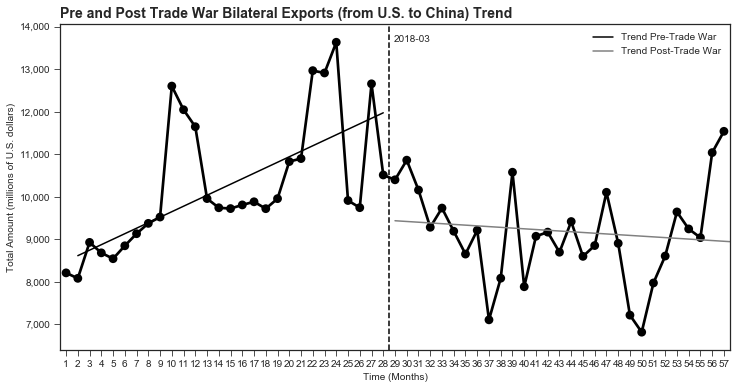

In [10]:
plot_its_result(bilateral_its_df, res_exports, "time", "exports", "2018-03", "Pre and Post Trade War Bilateral Exports (from U.S. to China) Trend")

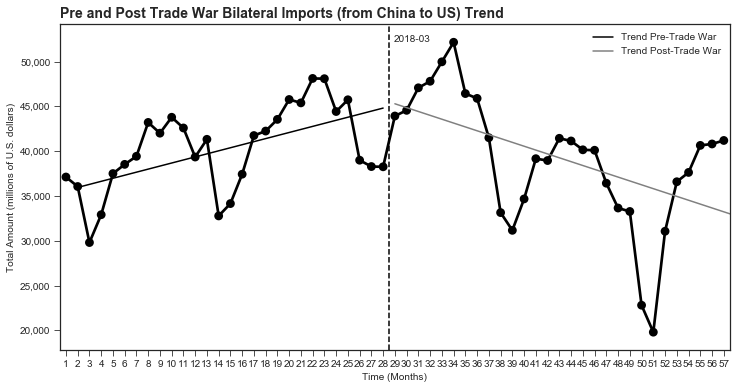

In [11]:
plot_its_result(bilateral_its_df, res_imports, "time", "imports", "2018-03", "Pre and Post Trade War Bilateral Imports (from China to US) Trend")

From the regression results and the plot, we can find that:

...

## 2. Does the increasing tariff have direct impacts on the trade？